In [1]:
import pm4py

event_log = pm4py.read_xes("data/Road_Traffic_Fine_Management_Process.xes")


/Users/leonardorossi/Desktop/UNI/Semester5/Process mining/fs24-process-mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 150370/150370 [00:13<00:00, 11396.53it/s]


# Session 1

## Task 1.1

- *a)* 2000-01-01 00:00:00+00:00 to 2013-06-18 00:00:00+00:00
- *b)* 113
- *c)*
    - *min:* 0.0
    - *median:* 35.0
    - *max:* 4351.0
    - *recommendation:* The median is very distant from the maximum, in fact only 9 entries have an initial fine amount of over 900. 
- *d)* 4,160 / 4124

# Session 2

## Task 1

In [2]:
import pandas as pd


# First, sort by case identifier and by time or event order if available
event_log = event_log.sort_values(by='case:concept:name')

event_log['paymentAmount'] = event_log['paymentAmount'].fillna(0)

# Now, calculate the cumulative sum for each case
event_log['cumulativePayment'] = event_log.groupby('case:concept:name')['paymentAmount'].cumsum()


- *a)* 87.0
- *b)* The cumulativePayment and totoalPaymentAmount only corresponds 13% of the times. This is largely due to the fact that a lot of entries have missing values and comparing two of those results in "False". Also in the totoalPaymentAmount '0' and 'Missing Value' is used inconsistently. This observation can be enforced my filtering the cumulativePayment column for 'Is not missing', because then 93% of the two columns correspond.


In [3]:
import pandas as pd

# Compare the newly calculated cumulativePayment with the existing totalPaymentAmount
event_log['is_correct'] = event_log['cumulativePayment'] == event_log['totalPaymentAmount']



## Task 2


In [4]:
# Calculate the total liability, which is the sum of the fine (amount) and any expenses (expense)
event_log['amount'] = event_log['amount'].fillna(0)
event_log['expense'] = event_log['expense'].fillna(0)
event_log['amount_total'] = event_log.groupby('case:concept:name')['amount'].cumsum() 
event_log['expense_total'] = event_log.groupby('case:concept:name')['expense'].cumsum()

event_log['totalLiability'] = event_log['amount_total'] + event_log['expense_total']

# Step 4: Calculate the outstanding balance as the total liability minus cumulative payments
event_log['outstanding_balance'] = event_log['totalLiability'] - event_log['cumulativePayment']


- *a)* 
    - *A10001:* 123
    - *A10004:* 123
    - *A10018:* 44

- *b)* 

## Task 3


In [5]:
event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'])

# Create the initial case log by grouping the event log by 'case:concept:name'
case_log = event_log.groupby('case:concept:name').agg(
    start_time=('time:timestamp', 'min'),   # Earliest event time
    end_time=('time:timestamp', 'max'),     # Latest event time
    number_of_events=('case:concept:name', 'count'),  # Count the number of events for each case
    initial_fine_amount=('amount', 'first')  # First non-missing value in the 'amount' column
).reset_index()

- *a)* 


In [6]:
import plotly.express as px

fig = px.histogram(case_log, x='initial_fine_amount', log_y=True, nbins=100)
fig.update_layout(bargap=0.2)
fig.show()

- *b)* 
    - A large number of fines are clustered towards the lower end, particularly below 500.
    - As we move to higher fine amounts, the frequency drops drastically.

## Task 4

In [7]:
case_log = event_log.groupby('case:concept:name').agg(
    start_time=('time:timestamp', 'min'),   # Earliest event time
    end_time=('time:timestamp', 'max'),     # Latest event time
    number_of_events=('case:concept:name', 'count'),  # Count the number of events for each case
    initial_fine_amount=('amount', 'first'),  # First non-missing value in the 'amount' column
    final_outstanding_payment= ('outstanding_balance', 'last')
).reset_index()

# histogram plot
fig2 = px.histogram(case_log, x='final_outstanding_payment', log_y=True, nbins=100)
fig2.update_layout(bargap=0.2)
fig2.show()


    - there are some cases where offenders overpaid or are just owed money
    - the majority of final outstanding payments lie between -300 and 2500
    - going upwards there are only a few sparse cases
    

## Task 5


In [8]:
# First, create a summary of the dismissal status for each case
dismissal_summary = event_log.groupby('case:concept:name')['dismissal'].apply(
    lambda x: x.isin(['G', '#']).any()
).reset_index()

# Merge this summary with the case log on the 'case:concept:name' column
case_log = case_log.merge(dismissal_summary, on='case:concept:name', how='left')

# Rename the 'dismissal' column in the case log to 'is_dismissed'
case_log.rename(columns={'dismissal': 'is_dismissed'}, inplace=True)

# Fill any missing values in 'is_dismissed' with False (since missing means not dismissed)
case_log['is_dismissed'].fillna(False, inplace=True)

case_log['is_fully_paid'] = case_log['final_outstanding_payment']==0

case_log['sent_to_credit_collection'] = event_log['concept:name'] == 'Send for Credit Collection'

/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_26100/2401532921.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





- *a)* 


/Users/leonardorossi/Desktop/UNI/Semester5/Process mining/fs24-process-mining/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/leonardorossi/Desktop/UNI/Semester5/Process mining/fs24-process-mining/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

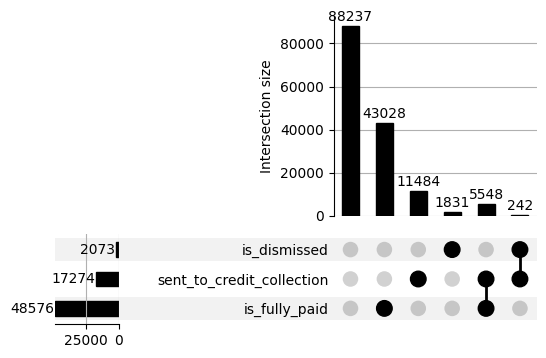

In [9]:
from upsetplot import UpSet, from_indicators

UpSet(from_indicators(['is_dismissed', 'is_fully_paid', 'sent_to_credit_collection'],
data=case_log),
show_counts=True).plot()

- *b)* 
    - Most cases (88,237) did not result in dismissal, full payment, or credit collection (all boolean features are False).
    - A large number of cases (43,028) have been fully paid, without being dismissed or sent to credit collection.
    - There are smaller groups of cases that were either dismissed, sent to credit collection, or paid, with varying combinations of these outcomes.

## Task 6


In [12]:
df = case_log.groupby('case:concept:name').agg(
    initial_fine_amount=('initial_fine_amount', 'max'),
    final_outstanding_payment=('final_outstanding_payment', 'max'))

fig3 = px.scatter(df, 
                 x='initial_fine_amount', 
                 y='final_outstanding_payment', 
                 title='Scatter Plot of Initial Fine Amount vs Final Outstanding Balance',
                 labels={'initial_fine_amount':'Initial Fine Amount', 
                         'final_outstanding_payment':'Final Outstanding Balance'},
                 width=700)

fig3.show()

- For initial fines in the lower range (below 1000), there seems to be a loose positive correlation between the initial fine amount and the final outstanding balance. As the fine increases, there is a tendency for the final balance to be positive, suggesting that larger fines are more likely to have an outstanding balance.

- There are a few outliers where the final outstanding balance is significantly high, even when the initial fine was not that large. For example, cases with an initial fine around 0 have a final outstanding balance exceeding 5,000. These might be cases where interest or penalties accumulated over time, or the case was sent to credit collection.

- A few points have negative final outstanding balances, indicating overpayment or cases where fines were reduced or dismissed.


## Task 7
- The employee with resource 29 handled 18% of all cases where the org:resource entry is not missing. This employee deducted a minimum of 2 points and a median of 5 points from offenders driving licences.

- 58/66 cases where 10 points (which is the highest amount in the log) where deducted from the offender, violated article number 142. After some research we found out that following article 142 10 points are deducted when exceeding speed limits by more than 60 km/h

# Session 3

## Task 1

- *a)* 
    - *Variant 1:* This process involves creating a fine, followed by a series of steps such as sending the fine, inserting a fine notification, adding a penalty, and finally sending the fine for credit collection.
    - *Variant 2:* This process is much shorter, involving creating a fine and then immediately payment within a short time.
    - *Variant 3:* This variant consists of creating a fine and then sending the fine with a significant delay.
    - *Variant 4:* This variant involves creating a fine, sending the fine with a delay, inserting a fine notification, adding a penalty and finally a payment by the offender.

    Unexpected behaviour:   
    - In variant 2 the fine is immediatly payed without it being sent, how is the offender informed about the violation?
    - In all the variants 1,3,4 the interval between fine creation and it being sent is mostly over 100 days, why does it take so long?

- *b)* 88.29%
- *c)* <img src="process_map.png" alt="Alt Text" style="width: 500px;"/>


## Task 2

- *a)* 
    - *Observation 1:* Out of the 79'860 fine notifications, only 3'891 are directly paid while 72'334 are added a penalty. 
    - *Observation 2:* Most of the cases with added penalty are sent to credit collection and only a small part is paid directly. This is probably a costly effort, hence it would be a good investigation point to see if resources could be saved.
    - *Observation 3:*
- *b)* 
- *c)*

## Task 3

- *a)* 
- *b)* 
- *c)*

## Task 4

## Task 5

# Analytics Lists

## Interesting Findings
- The median of the initial fine amount is very distant from the maximum, in fact only 9 entries have an initial fine amount of over 900. 


## Process Improvements 
- All the missing values in the amount and payment columns turned out to be a hurdle for addition and other multiplications so we replaced them with 0.

## Open Questions
- Why are so many cases closed even if the final outstanding payment is not equal to 0?